In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score,classification_report,make_scorer, roc_auc_score

import shap
import dataframe_image as dfi
import cv2

In [21]:
df = pd.read_csv('../Data/raw_df.csv')
df = df.drop_duplicates(keep='first').reset_index(drop=True)

DoS = list([
    'smurf', 'pod', 'neptune', 'teardrop', 'land', 'apache2', 
    'back', 'udpstorm', 'mailbomb', 'processtable'
])

U2R = list([

    'buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'xterm', 'ps', 
    'httptunnel', 'sqlattack', 'worm', 'snmpguess'
])

R2L = list([
    'guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
    'snmpgetattack',  'named', 'xlock', 'xsnoop', 'sendmail'
])

Probe = list([
    'portsweep', 'ipsweep', 'nmap', 'saint', 'satan', 'mscan'
])

for attack in Probe:
    df['deu_ruim_ou_nao']=df['deu_ruim_ou_nao'].str.replace(attack,'Probe')
    
for attack in DoS:
    df['deu_ruim_ou_nao']=df['deu_ruim_ou_nao'].str.replace(attack,'DoS')

for attack in U2R:
    df['deu_ruim_ou_nao']=df['deu_ruim_ou_nao'].str.replace(attack,'U2R')

for attack in R2L:
    df['deu_ruim_ou_nao']=df['deu_ruim_ou_nao'].str.replace(attack,'R2L')

In [22]:
X = df_pp.iloc[:,:-1]
y = df_pp.iloc[:,-1]

In [23]:
def SHAP_topk_features(df_pp, number_of_instances, k):

    now = datetime.now()
    print(f'{now} - SHAP feature selection Initialized!')

    X = df_pp.iloc[:,:-1]
    y = df_pp.iloc[:,-1]

    train_X, test_X, train_y, test_y = train_test_split(X,y, random_state=42)
    rf = RandomForestClassifier(random_state=42).fit(train_X.values, train_y.values)
    shap_df = pd.DataFrame()

    for target in list(test_y.value_counts().index):   
        i = []
        v = []

        for index, value in zip(range(len(test_y)), test_y):    
            i.append(index)
            v.append(value)
        
        y_val = pd.Series(v,i)
        y_val = list(y_val[y_val==target].index)

        idx_threshold = number_of_instances
        final_idx = []

        for idx in y_val:
            if idx_threshold > 0:
                row_instance = test_X.iloc[idx]
                row_pred = row_instance.values.reshape(1, -1)

                if float(rf.predict_proba(row_pred)[0][target]) == 1.0:
                    final_idx.append(idx)
                    idx_threshold = idx_threshold - 1
            else:
                break

        temp_df = pd.DataFrame()

        for idx in final_idx:
            row_instance = test_X.iloc[idx]
            row_pred = row_instance.values.reshape(1, -1)
            
            explainer = shap.TreeExplainer(rf)
            shap_values = explainer.shap_values(row_instance)

            series_idx = row_instance.index
            series_val = shap_values[target]

            feature_series = pd.Series(series_val, series_idx)
            
            shap_df_temp = feature_series.to_frame().rename(columns={0:'shap_value'}).rename_axis('features').reset_index()
            temp_df = temp_df.append(shap_df_temp, ignore_index = True)

        temp_df = temp_df.sort_values(by=['shap_value'], ascending=False).drop_duplicates(subset='features', keep='first')
        shap_df = shap_df.append(temp_df, ignore_index = True)    

    shap_df = shap_df.sort_values(by=['shap_value'], ascending=False).drop_duplicates(subset='features', keep='first')
    shap_features = list(shap_df['features'].iloc[:k])

    now = datetime.now()
    print(f'{now} - SHAP feature selection Successful!')

    return shap_features

In [24]:
number_of_instances=10
k=28
SHAP_features = SHAP_topk_features(df_pp, number_of_instances, k)

2022-02-12 20:00:18.329584 - SHAP feature selection Initialized!
2022-02-12 20:00:27.014243 - SHAP feature selection Successful!


In [39]:
len(X[X.columns[-1]].value_counts())

93

In [25]:
def model_performance(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    clf=RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

    sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred)
    print(sk_report)

    performance_dictionary={'Class':[],'Accuracy':[],'F1_Score':[],'Precision':[],'Recall':[]}

    f1 = list(f1_score(y_test, y_pred, average=None))
    matrix = confusion_matrix(y_test, y_pred)
    acc = list(matrix.diagonal()/matrix.sum(axis=1))
    pr = list(precision_score(y_test, y_pred, average=None))
    rl = list(recall_score(y_test, y_pred, average=None))
    #ra = list(roc_auc_score(y_test, y_pred , multi_class='ovo', average=None))

    for i in range(len(f1)):

        performance_dictionary['Class'].append(i)
        performance_dictionary['Accuracy'].append(acc[i])
        performance_dictionary['F1_Score'].append(f1[i])
        performance_dictionary['Precision'].append(pr[i])
        performance_dictionary['Recall'].append(rl[i])
        #performance_dictionary['ROC_AUC'].append(ra[i])


    df = pd.DataFrame.from_dict(performance_dictionary)

    train_sizes = range(1,len(X_train),10000)

    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = RandomForestClassifier(),
    X = X,
    y = y, 
    train_sizes = train_sizes, 
    cv = 5,
    scoring = 'accuracy')

    # print('Training scores:\n\n', train_scores)
    # print('\n', '-' * 70) # separator to make the output easy to read
    # print('\nValidation scores:\n\n', validation_scores)

    return df, train_scores, validation_scores

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


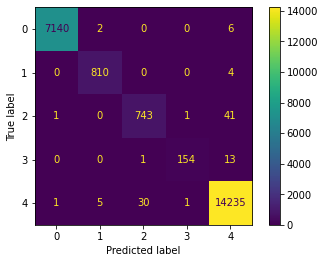

              precision    recall  f1-score   support

           0   0.999720  0.998881  0.999300      7148
           1   0.991432  0.995086  0.993256       814
           2   0.959948  0.945293  0.952564       786
           3   0.987179  0.916667  0.950617       168
           4   0.995524  0.997408  0.996465     14272

    accuracy                       0.995429     23188
   macro avg   0.986761  0.970667  0.978440     23188
weighted avg   0.995408  0.995429  0.995406     23188



,Class,Accuracy,F1_Score,Precision,Recall
0,0,0.998881,0.999300,0.999720,0.998881
1,1,0.995086,0.993256,0.991432,0.995086
2,2,0.945293,0.952564,0.959948,0.945293
3,3,0.916667,0.950617,0.987179,0.916667
4,4,0.997408,0.996465,0.995524,0.997408


In [26]:
X=df_pp[SHAP_features]
y=df_pp.iloc[:,-1]

SHAP_perf_df, train_scores, validation_scores=model_performance(X,y)
SHAP_perf_df

In [42]:
int(len(train_scores)*0.8)

4

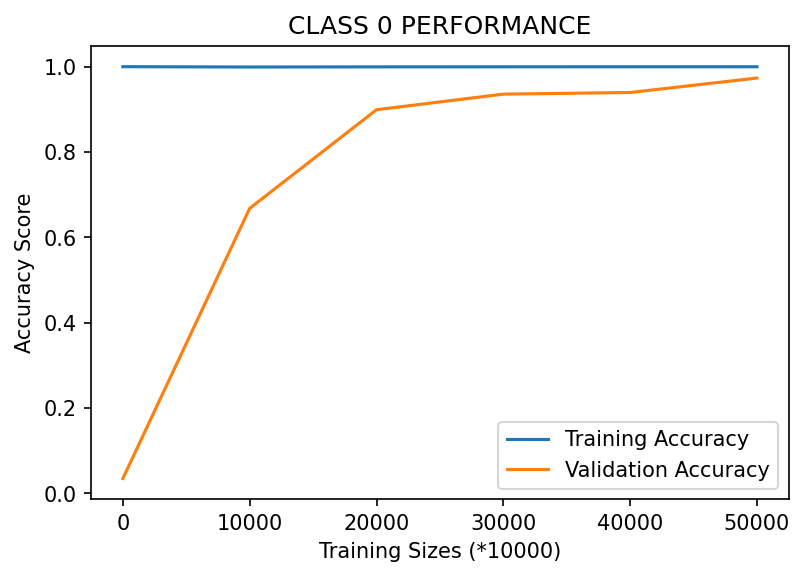

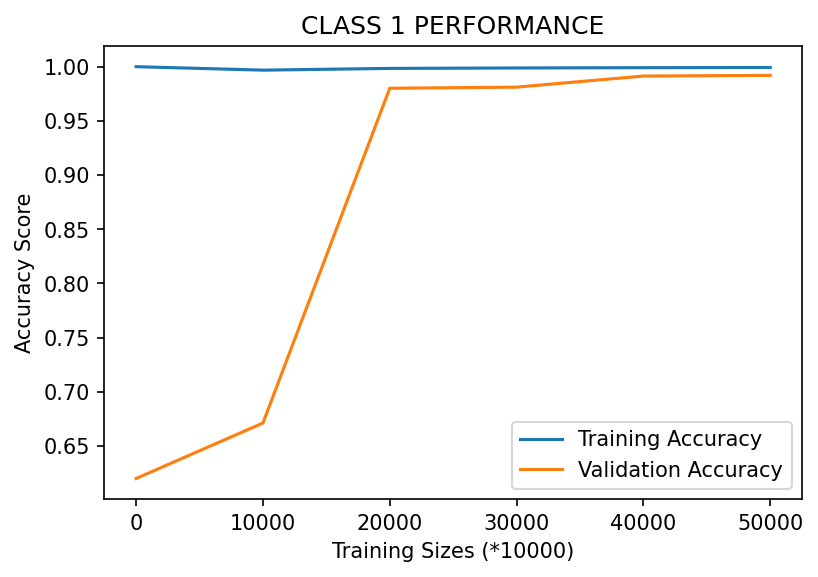

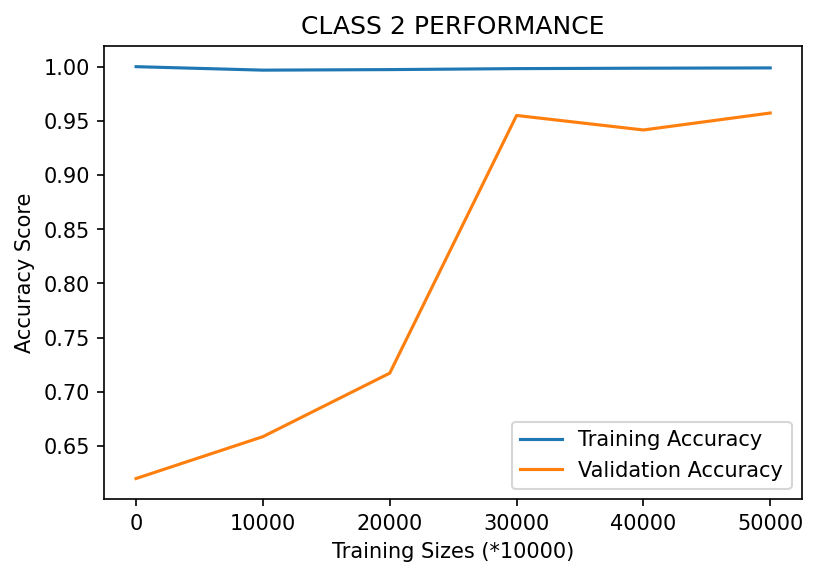

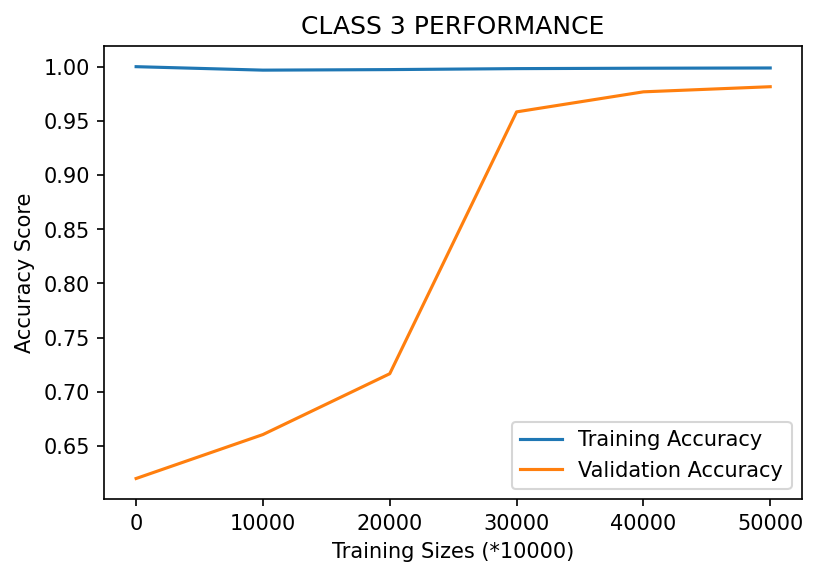

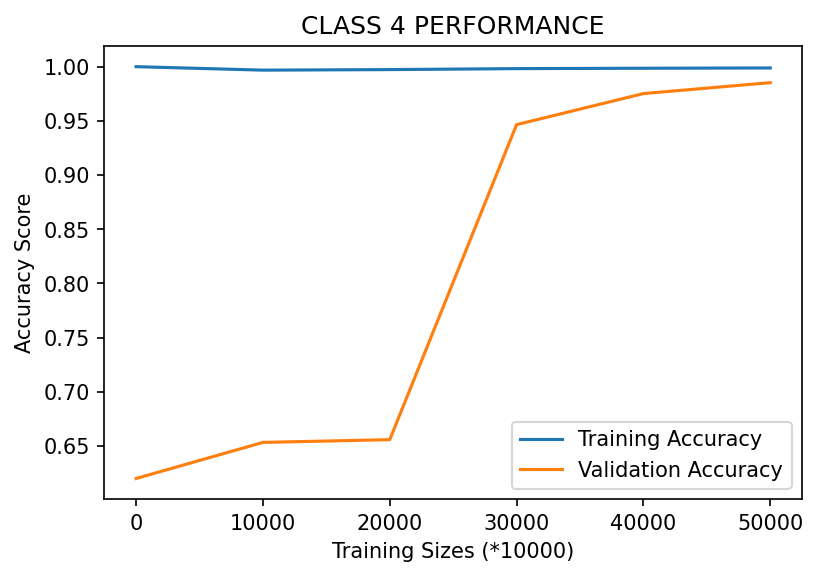

In [33]:
plt.rcParams['figure.dpi'] = 150
for i in range(5):

    length = list(range(len(train_scores)))
    x_axis = [x*10000 for x in length]
    y_axis_train = train_scores[:,i]
    y_axis_val = validation_scores[:,i]

    df = pd.DataFrame({'Training Accuracy': y_axis_train,
                   'Validation Accuracy': y_axis_val
                   }, index=x_axis)
    ax = df.plot.line()

    plt.title('CLASS ' + str(i) + ' PERFORMANCE')
    plt.xlabel('Training Sizes (*10000)')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

In [12]:
len(train_scores)

55

In [13]:
train_scores

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 0.98801199, 0.98801199, 0.98801199, 0.98801199],
       [1.        , 0.99150425, 0.99150425, 0.99150425, 0.99150425],
       [0.99933356, 0.99366878, 0.99366878, 0.99366878, 0.99366878],
       [0.99900025, 0.99450137, 0.99450137, 0.99450137, 0.99450137],
       [0.99920016, 0.99540092, 0.99540092, 0.99540092, 0.99540092],
       [0.99916681, 0.99566739, 0.99566739, 0.99566739, 0.99566739],
       [0.99885731, 0.99542922, 0.99542922, 0.99542922, 0.99542922],
       [0.99900012, 0.9960005 , 0.9960005 , 0.9960005 , 0.9960005 ],
       [0.99911121, 0.99644484, 0.99644484, 0.99644484, 0.99644484],
       [0.99920008, 0.99680032, 0.99680032, 0.99680032, 0.99680032],
       [0.99927279, 0.99709117, 0.99709117, 0.99709117, 0.99709117],
       [0.99933339, 0.99733356, 0.99733356, 0.99733356, 0.99733356],
       [0.99938466, 0.99753865, 0.99753865, 0.99753865, 0.99753865],
       [0.99942861, 0.99771445, 0.